In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
import matplotlib.cm as mcm
import numpy as np
from scipy.signal import savgol_filter
from scipy.stats import gaussian_kde, pearsonr
import geopandas as gpd

from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction, skipped_timeseries_formatting
import seaborn as sns
import networkx as nx

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams["axes.facecolor"] = "white"

# Figure 1: Network analysis of SARS-CoV-2 similarity in North America.
We use the PhyloSor metric to measure the genomic similarity between all suitably sequenced locations in North America, and determine that the country experience smallworldness at the begining and during periods of high COVID-19 incidence.


We first load in the results from the PhyloSor analysis. These are the output of the `monterey` pipeline. We include comparisons between all locations for months which they sequenced more than 30 genomes. Additionally, some of the network analyses we do require edge length to be specified as a distance, rather than a similarity metric which PhyloSor is. We calculate PhyloSor distance as the reciprical of the PhyloSor similarity.

In [2]:
def correct_names( entry ):
    return_value = entry.replace( "_", ", " )
    if return_value in ["British Columbia", "Ontario", "Alberta", "Québec", "Saskatchewan", "Manitoba", "Nova Scotia"]:
        return_value += ", CAN"
    elif return_value in ["Baja California", "Yucatán"]:
        return_value += ", MEX"
    return return_value

min_sequences = 30

res = pd.read_csv( "../data/phylosor_results_all.csv", parse_dates=["date"] )
res = res.loc[(res["countA"]>=min_sequences)&(res["countB"]>=min_sequences)]
#res = res.loc[res["siteA"].str.endswith( ("_USA", "_CAN", "_MEX", "_CA") )&res["siteB"].str.endswith( ("_USA", "_CAN", "_MEX", "_CA") )]
res["siteB"] = res["siteB"].apply( correct_names )
res["siteA"] = res["siteA"].apply( correct_names )
res = res.drop( columns=["num", "kind"] )
res["reciprical_value"] = 1 / res["value"]
res.head()

,blA,blB,blBoth,date,siteA,countA,siteB,countB,value,value_turn,reciprical_value
1,651.0,174.0,61.0,2020-03-01,"California, USA",686,"Colorado, USA",166,0.147879,0.350575,6.762295
2,128.0,223.0,19.0,2020-04-01,"California, USA",101,"Colorado, USA",198,0.108262,0.148438,9.236842
4,223.0,263.0,29.0,2020-06-01,"California, USA",89,"Colorado, USA",77,0.119342,0.130045,8.379310
5,214.0,814.0,43.0,2020-07-01,"California, USA",64,"Colorado, USA",321,0.083658,0.200935,11.953488
7,380.0,723.0,45.0,2020-09-01,"California, USA",61,"Colorado, USA",240,0.081596,0.118421,12.255556


We next calculated the graph efficiency of the PhyloSor network to estimate smallworldness. Briefly, the global efficiency of a graph measures how optimally information can flow in a network, or in this case how efficiently a virus can be transmitted across it. In our case, efficiency of the graph is the average PhyloSor similarity between each pair of nodes in a graph. This measure can vary from 0, indicating that locations in the graph are not similar at all, to 1, indicating that viral similarity is high between all locations.


We calculate this metric for each month of the pandemic by bootstrapping nodes in the graph 100 times. As a result this cell takes a few minutes to run, so we save the results to file.

In [ ]:
def weighted_global_efficiency( graph, weight ):
    """ Returns the global efficiency of the graph using distance as indicated by weight.
    Parameters
    ----------
    graph : networkx.Graph
    weight : str
        edge weight will be accessed via the edge attribute with this key.

    Returns
    -------
    float
        The average global efficiency of the graph.
    """
    n = len(graph)
    denom = n * (n - 1)
    if denom != 0:
        lengths = nx.all_pairs_dijkstra_path_length(graph, weight=weight)
        g_eff = 0
        for source, targets in lengths:
            for target, distance in targets.items():
                if (distance > 0) & (target != source):
                    g_eff += 1 / distance
        g_eff /= denom
    else:
        g_eff = 0

    return g_eff

results = {
    "date" : [],
    "efficiency" : [],
    "lower" : [],
    "upper" : []
}

bootstraps = 100

for date, df in res.groupby( "date" ):
    boot_results = []
    date_graph = nx.from_pandas_edgelist( df, source="siteA", target="siteB", edge_attr="reciprical_value" )
    for _ in range( bootstraps ):
        sampled_nodes = np.random.choice( date_graph.nodes, size=len( date_graph.nodes ), replace=True )
        boot_graph = date_graph.subgraph( sampled_nodes )
        boot_results.append( weighted_global_efficiency(boot_graph, "reciprical_value" ) )

    limits = np.quantile( boot_results, q=[0.025,0.5,0.975] )
    results["date"].append( date )
    results["lower"].append(limits[0])
    results["efficiency"].append( limits[1])
    results["upper"].append( limits[2] )

results = pd.DataFrame( results )
results.to_csv( "../data/phylosor_network_efficiency.csv", index=False )

Here we load the cached results from file.

In [3]:
results = pd.read_csv( "../data/phylosor_network_efficiency.csv", parse_dates=["date"] )
results.tail()

,date,efficiency,lower,upper
27,2022-06-01,0.188021,0.174837,0.202577
28,2022-07-01,0.187537,0.172554,0.202962
29,2022-08-01,0.175518,0.164327,0.194468
30,2022-09-01,0.187930,0.175199,0.202011
31,2022-10-01,0.211675,0.197505,0.234606


We first determine whether there is a correlation between the efficiency of the network and the stringency of the COVID prevention strategies in the US. We hypothesize that this correlation is negative because relaxation restrictions should increase the frequency of transmission between locations.

Here we load in stringency data for the US provided by Our World in Data.

In [4]:
stringency = pd.read_csv( "https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=["date"], usecols=["location", "date", "stringency_index"] )
stringency = stringency.loc[stringency["location"]=="United States"]
stringency = stringency.drop( columns=["location"] )
stringency["month"] = stringency["date"].to_numpy().astype( "datetime64[M]")
stringency = stringency.groupby( "month" )["stringency_index"].agg( ["mean", lambda x: x.quantile( 0.025 ), lambda x: x.quantile( 0.975 )] )
stringency.columns = ["stringency", "stringency_lower", "stringency_upper"]


test = results.merge( stringency, left_on="date", right_index=True )
test["date_end"] = test["date"] + pd.DateOffset( months=1 )
pear_results = pearsonr( test["efficiency"], test["stringency"] )
p_value = "< 0.001" if pear_results.pvalue < 0.001 else f"= {pear_results.pvalue:.3f}"
print( f"Pearson r = {pear_results.statistic:.2f} [95% CI: {pear_results.confidence_interval().low:.2f} to {pear_results.confidence_interval().high:.2f}]; P {p_value}")

Pearson r = -0.69 [95% CI: -0.84 to -0.45]; P < 0.001


Next we looked at Gini index to quantify heterogeneity in each locations' average similarity to other locations. In this case, a low value indicates all locations have identical similar to each other, while a high value means relative few locations have a high similarity to other locations.

We calculate this metric for each month of the pandemic by bootstrapping nodes in the graph 100 times. This cell takes a few minutes to run, so we save the results to file.

In [ ]:
# Calculate nodal efficiency for each location
def nodal_efficiency( graph, weight ):
    """ Returns the nodal efficiency of each node in the graph using the distance indicated by weight.
    Parameters
    ----------
    graph : networkx.Graph
    weight : str
        edge weight will be accessed via the edge attribute with this key.

    Returns
    -------
    list( float )
        Nodal efficiency of each node in graph.
    """
    ne = list()
    lengths = nx.all_pairs_dijkstra_path_length(graph, weight=weight)
    for source, targets in lengths:
        carrier = 0
        for target, distance in targets.items():
            if (distance > 0) & (target != source):
                carrier += 1 / distance
        ne.append( carrier / ( len( graph ) - 1 ) )
    return ne


def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

ne_results = {
    "date" : [],
    "gini_index" : [],
    "lower" : [],
    "upper" : [],
}

bootstraps = 100

for date, df in res.groupby( "date" ):
    boot_results = []
    date_graph = nx.from_pandas_edgelist( df, source="siteA", target="siteB", edge_attr="reciprical_value" )
    for _ in range( bootstraps ):
        sampled_nodes = np.random.choice( date_graph.nodes, size=len( date_graph.nodes ), replace=True )
        boot_graph = date_graph.subgraph( sampled_nodes )
        nes = nodal_efficiency( boot_graph, weight="reciprical_value" )
        boot_results.append( gini( nes ) )

    limits = np.quantile( boot_results, q=[0.025,0.5,0.975] )
    ne_results["date"].append( date )
    ne_results["lower"].append(limits[0])
    ne_results["gini_index"].append( limits[1])
    ne_results["upper"].append( limits[2] )

ne_results = pd.DataFrame( ne_results )
ne_results.to_csv( "../data/phylosor_network_heterogeneity.csv", index=False )
ne_results.head()

We load the cached results here to speed things up.

In [5]:
ne_results = pd.read_csv( "../data/phylosor_network_heterogeneity.csv", parse_dates=["date"] )
ne_results.head()

,date,gini_index,lower,upper
0,2020-03-01,0.122209,0.103518,0.132655
1,2020-04-01,0.117153,0.105190,0.133172
2,2020-05-01,0.148773,0.124802,0.171292
3,2020-06-01,0.132777,0.113446,0.152220
4,2020-07-01,0.106836,0.082891,0.126439


Here we plot how the Gini index of average similarity changes over time. This will be supplimental figure 3 of the paper.

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/analyses/utils.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )


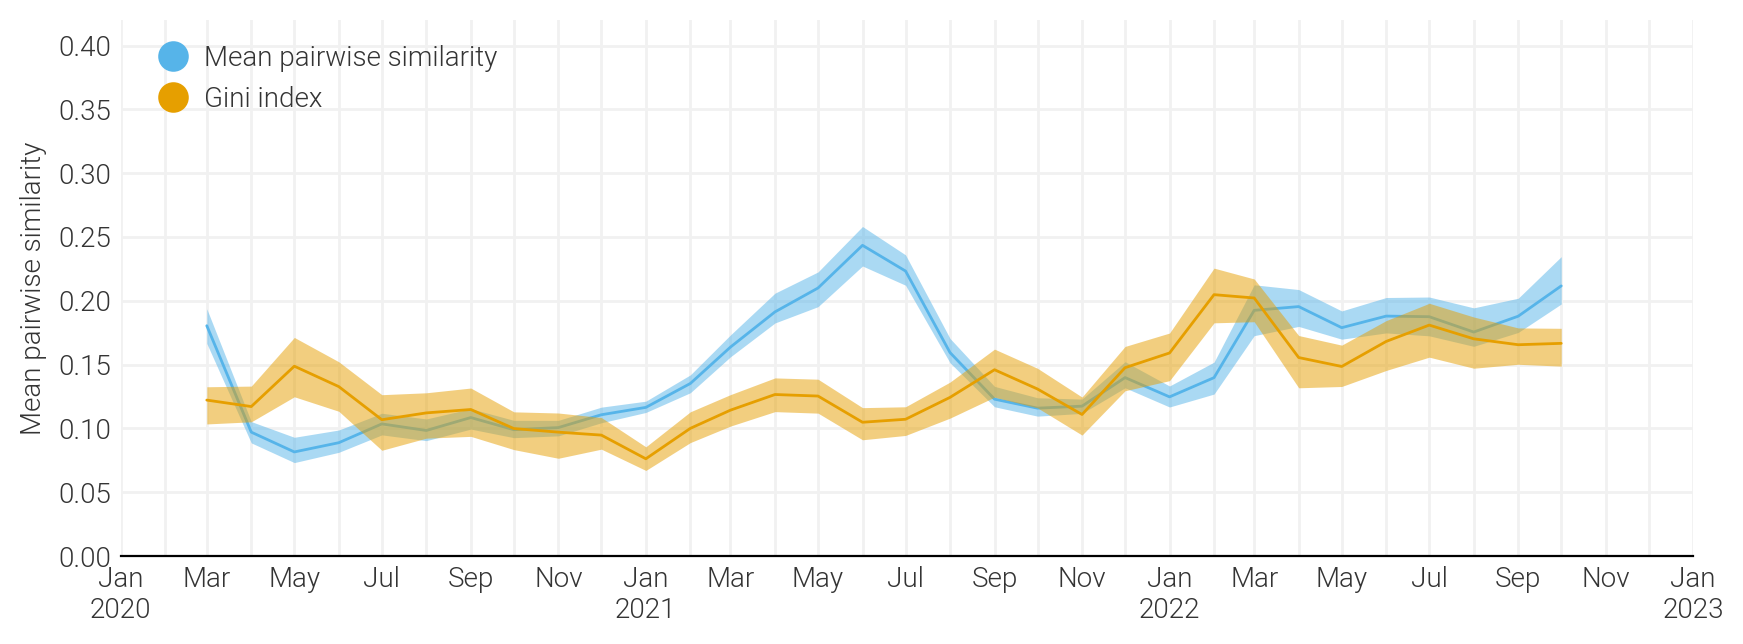

In [10]:
fig, ax = plt.subplots( dpi=200, figsize=(9,3.5) )
ax.fill_between( x="date", y1="lower", y2="upper", data=ne_results, color="#E69F00", alpha=0.5, linewidth=0, zorder=10 )
ax.plot( "date", "gini_index", data=ne_results, color="#E69F00", solid_capstyle="round", linewidth=1, zorder=11 )

ax.fill_between( x="date", y1="lower", y2="upper", data=results, color="#56B4E9", alpha=0.5, linewidth=0, zorder=8)
ax.plot( "date", "efficiency", data=results, color="#56B4E9", solid_capstyle="round", linewidth=1, zorder=9 )

leg = [
    Line2D([0], [0], linestyle='none', marker='o', color="#56B4E9", label="Mean pairwise similarity", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="Gini index", markersize=10 )
]
ax.legend( handletextpad=0.1, handles=leg, frameon=False, fontsize=10, loc="upper left" )


basic_formatting( ax, spines=["bottom"], which="both", ylabel="Mean pairwise similarity", xsize=10, ysize=10, xlims=( pd.to_datetime( "2020-01-01" ), pd.to_datetime("2023-01-01") ), ylims=(0, 0.42) )

skipped_timeseries_formatting( ax )

plt.tight_layout()
fig.savefig( "../paper/figures/suppfigure3.png" )
fig.savefig( "../paper/figures/suppfigure3.pdf" )
plt.show()

To identify what are the most important locations in the phylosor network, we rank locations by their median nodal efficiencies. Basically, this should tell us the locations that are consistently similar to a greater portion of North America.


In [11]:
central = list()
for date, df in res.groupby( "date" ):
    date_graph = nx.from_pandas_edgelist( df, source="siteA", target="siteB", edge_attr="reciprical_value" )
    temp = nx.closeness_centrality( date_graph, distance="reciprical_value" )   # This should be eqivalent to the nodal efficiency I calculate above. but it outputs as a dictionary.
    temp = pd.DataFrame( temp, index=[date] ).T
    central.append( temp )

central = pd.concat( central, axis=1 )

We make a quick diagnostic plot to determine how much temporal variation there is in centrality.

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/analyses/utils.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )


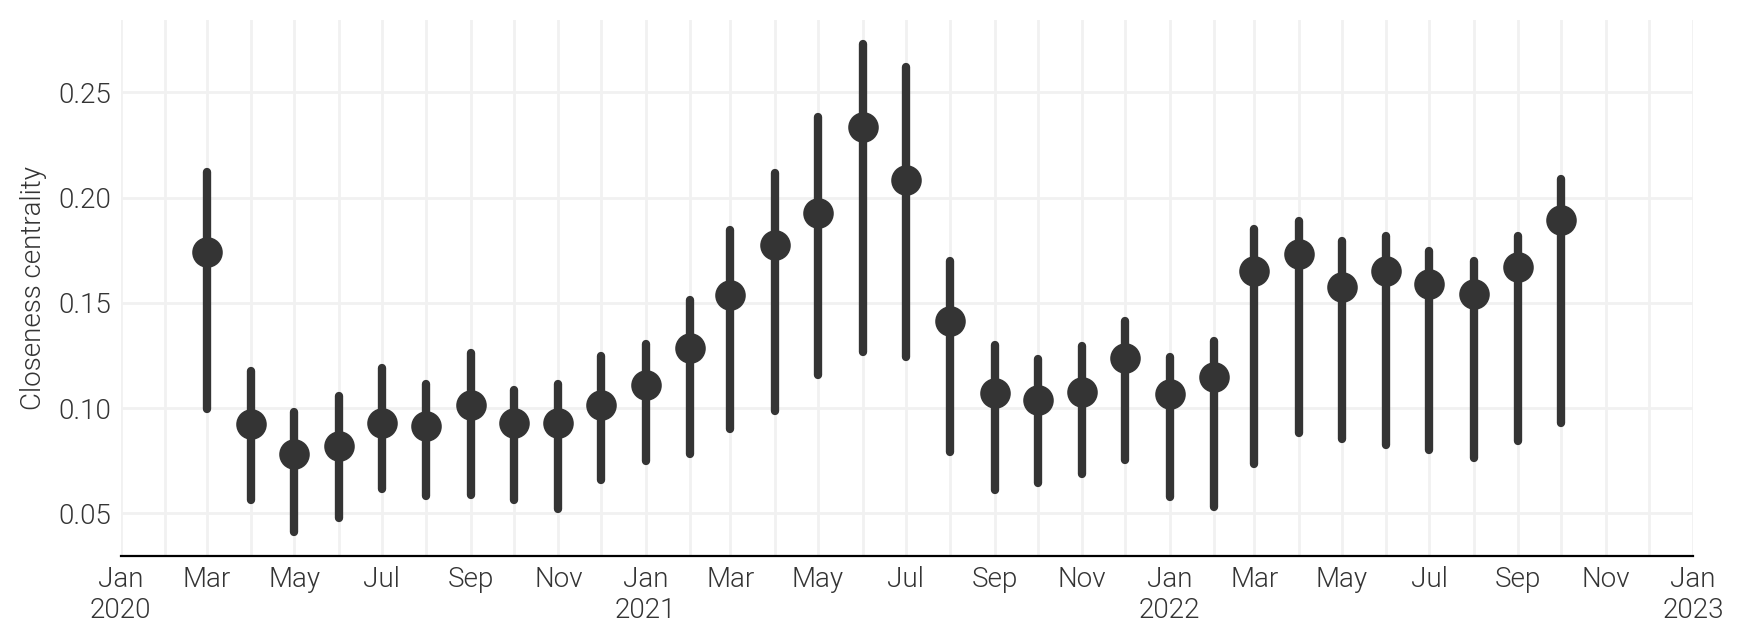

In [23]:
get_low = lambda x: x.quantile( 0.025 )
get_high = lambda x: x.quantile( 0.975 )

plot_df = central.agg( ["median", get_low, get_high] ).T.reset_index()
plot_df.columns = ["date", "median", "lower", "upper"]
fig, ax = plt.subplots( dpi=200, figsize=(9,3.5) )
ax.scatter( "date", "median", data=plot_df, color=COLOR, zorder=10, s=100 )
ln = ax.vlines( "date", "lower", "upper", data=plot_df, color=COLOR, zorder=9, linewidth=3 )
ln.set_capstyle( "round" )
basic_formatting(ax, which="both", ylabel="Closeness centrality", xsize=10, ysize=10, xlims=( pd.to_datetime( "2020-01-01" ), pd.to_datetime("2023-01-01") ), )
skipped_timeseries_formatting(ax)
plt.tight_layout()
#plt.savefig( "../figures/centrality_over_time.pdf" )
plt.show()

We plot the distribution of each locations' median similarity, while highlighting where San Diego falls in that distribution. This generates Figure 1B.

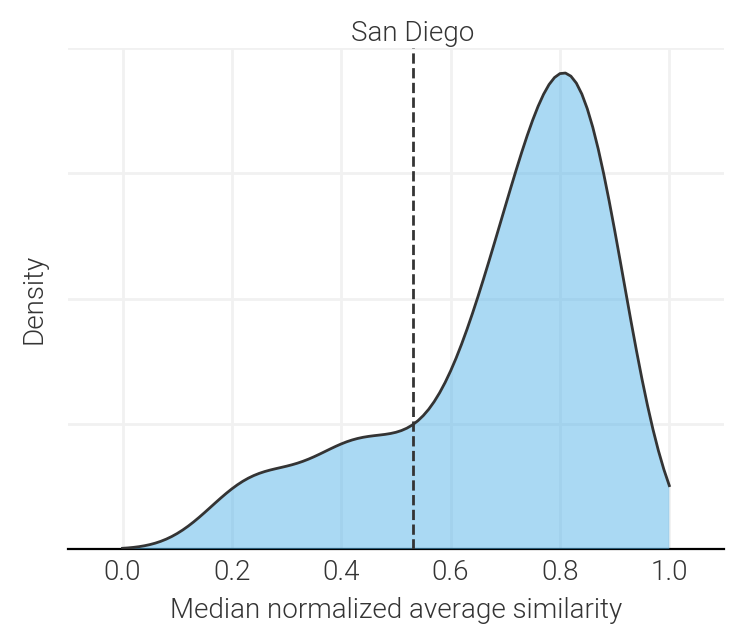

San Diego's centrality: 0.531
San Diego's percentile: 19.7%


In [24]:
fig, ax = plt.subplots( dpi=200, figsize=(4,3.5) )

data = central.apply( lambda x: (x - x.min()) / (x.max() - x.min())).median( axis=1 )
data.name = "centrality"
x_grid = np.linspace( 0, 1, 101 )
kde = gaussian_kde( data )
y_grid = kde.evaluate( x_grid )
y_grid = y_grid / y_grid.max() * 0.95
ax.plot([x for x in x_grid],y_grid,color=COLOR,lw=1,zorder=101)
ax.fill_between(x_grid,[y for y in y_grid], facecolor="#56B4E9", edgecolor='none', alpha=0.5, zorder=100)

sd_pos = data["San Diego, CA"]
ax.axvline( sd_pos, color=COLOR, linestyle="dashed", linewidth=1, zorder=102 )
ax.annotate( "San Diego", (sd_pos, ax.get_ylim()[1]), (0,3), textcoords="offset points", ha="center", size=10, color=COLOR )
ax.set_ylim( 0 )
basic_formatting( ax, which="both", ylabel="Density", xlabel="Median normalized average similarity", xlims=(-0.1, 1.1), ylims=(0,1), xsize=10, ysize=10 )
ax.tick_params( axis="x", rotation=0 )
ax.set_yticks( [0,0.25,0.5,0.75,1] )
ax.set_yticklabels( [] )
plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-network-centrality-normalized.pdf" )
plt.show()

sd_percentile = data.loc[data<sd_pos].shape[0] / data.shape[0]
print( f"San Diego's centrality: {sd_pos:.3f}" )
print( f"San Diego's percentile: {sd_percentile:.1%}")

Save median centrality measures to file in case they are included as a supplimentary table.

In [25]:
data.sort_values( ascending=False ).to_csv( "../paper/tables/centrality.csv" )

Lastly, to aid in producing figures for the paper, we plot the average pairwise similarity of all locations over time, 

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/analyses/utils.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )


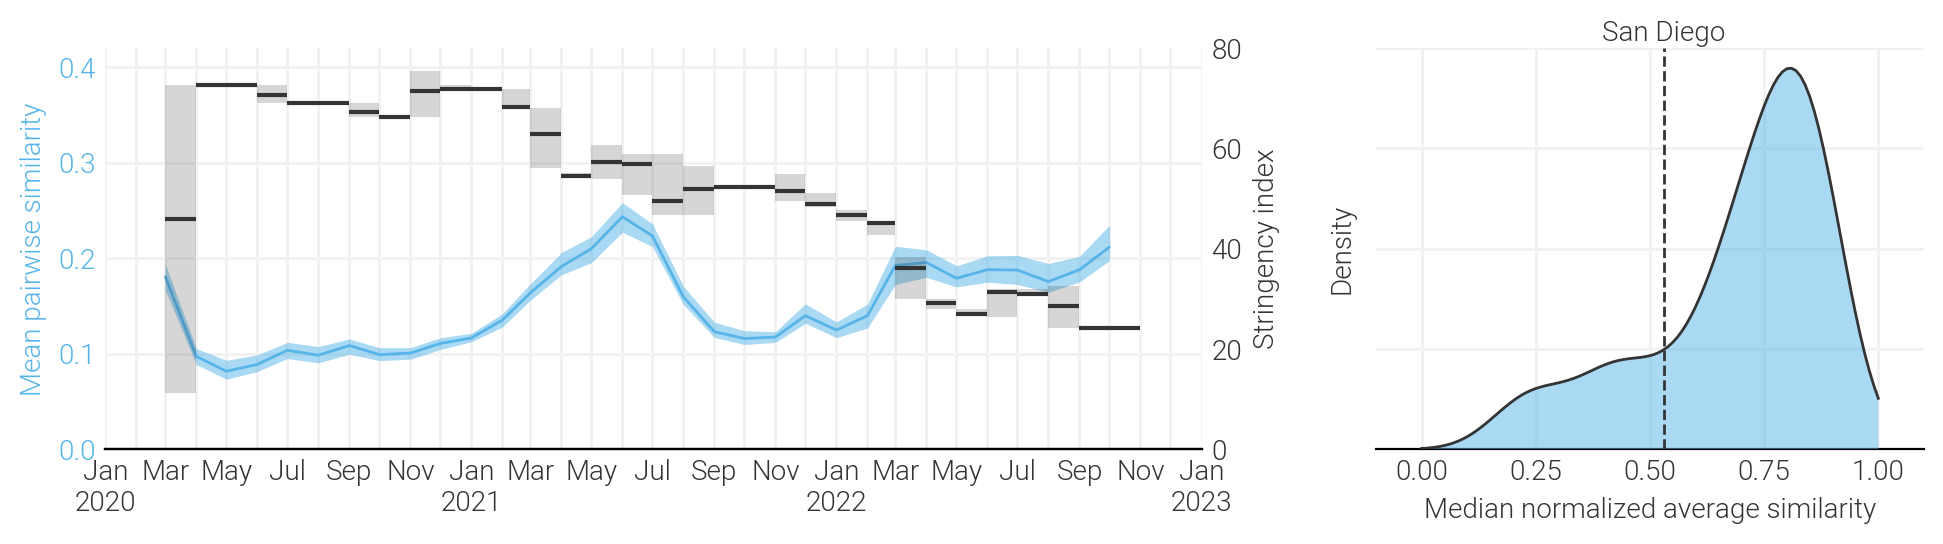

In [28]:
fig, ax = plt.subplots( dpi=200, figsize=(10,3), ncols=2, gridspec_kw={"width_ratios" :(0.6, 0.3)} )
ax2 = ax[0].twinx()

ax[0].fill_between( x="date", y1="lower", y2="upper", data=results, color="#56B4E9", alpha=0.5, linewidth=0, zorder=10 )
ax[0].plot( "date", "efficiency", data=results, color="#56B4E9", solid_capstyle="round", linewidth=1, zorder=11 )

ln = ax2.hlines( y="stringency", xmin="date", xmax="date_end", data=test, color=COLOR, zorder=5 )
ax2.fill_between( x="date", y1="stringency_lower", y2="stringency_upper", step="post", data=test, color=COLOR, alpha=0.2, zorder=4, linewidth=0 )

basic_formatting( ax[0], which="both", ylabel="Graph efficiency", xsize=10, ysize=10, xlims=( pd.to_datetime( "2020-01-01" ), pd.to_datetime("2023-01-01") ), ylims=(0, 0.42) )
basic_formatting( ax2, ylabel="Stringency index", xsize=10, ysize=10, xlims=( pd.to_datetime( "2020-01-01" ), pd.to_datetime("2023-01-01") ), ylims=(0, 80) )

ax[0].set_ylabel( "Mean pairwise similarity", color="#56B4E9" )
skipped_timeseries_formatting( ax[0] )
# Format axes ticks
ax[0].tick_params( axis="y", labelcolor="#56B4E9")
ax[0].legend().remove()
ax2.tick_params( axis="y", labelleft=False, right=False )
ax2.grid(False )


data = central.apply( lambda x: (x - x.min()) / (x.max() - x.min())).median( axis=1 )
data.name = "centrality"
x_grid = np.linspace( 0, 1, 101 )
kde = gaussian_kde( data )
y_grid = kde.evaluate( x_grid )
y_grid = y_grid / y_grid.max() * 0.95
ax[1].plot([x for x in x_grid],y_grid,color=COLOR,lw=1,zorder=101)
ax[1].fill_between(x_grid,[y for y in y_grid], facecolor="#56B4E9", edgecolor='none', alpha=0.5, zorder=100)

sd_pos = data["San Diego, CA"]
ax[1].axvline( sd_pos, color=COLOR, linestyle="dashed", linewidth=1, zorder=102 )
ax[1].annotate( "San Diego", (sd_pos, ax[1].get_ylim()[1]), (0,3), textcoords="offset points", ha="center", size=10, color=COLOR )
ax[1].set_ylim( 0 )
basic_formatting( ax[1], which="both", ylabel="Density", xlabel="Median normalized average similarity", xlims=(-0.1, 1.1), ylims=(0,1), xsize=10, ysize=10 )
ax[1].tick_params( axis="x", rotation=0 )
ax[1].set_yticks( [0,0.25,0.5,0.75,1] )
ax[1].set_yticklabels( [] )

plt.tight_layout()
plt.savefig( "../analyses/plots/figure1_phylosor-network-efficiency-centrality.pdf" )
plt.show()